In [17]:
import os
import gym
import math
import random
import argparse
import numpy as np
from collections import namedtuple
import sys
import cv2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use device: %s"%device)

Use device: cuda


In [18]:
# Please tune the hyperparameters
train_ep = 800
mem_capacity = 65000
batch_size = 128
lr = 0.00025
gamma = 0.999
epsilon_start = 1.0
epsilon_final = 0.1
epsilon_decay = 1000000
target_step = 10000
eval_per_ep = 10
save_per_ep = 50
save_dir = "./HW3/model"
log_file = "./HW3/log.txt"
load_model = None
train = True

In [19]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [20]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [21]:
class CNN(nn.Module):
    def __init__(self, h, w, outputs):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        def conv2d_size_out(size, kernel_size = 3, stride = 1):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w,8,4),4,2),3,1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h,8,4),4,2),3,1)
        linear_input_size = convw * convh * 64
        
        self.fc = nn.Linear(linear_input_size, 512)
        self.head = nn.Linear(512, outputs)
        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.leaky_relu(self.fc(x.view(x.size(0), -1)))
        return self.head(x)

In [22]:
actions = ["NOOP", "UP", "DOWN"]

In [23]:
class DQN(object):
    def __init__(self):
        self.BATCH_SIZE = batch_size
        self.GAMMA = gamma
        self.EPS_START = epsilon_start
        self.EPS_END = epsilon_final
        self.EPS_DECAY = epsilon_decay
        self.LEARN_RATE = lr
        self.TARGET_UPDATE = target_step

        self.action_dim = 3
        self.state_dim = (84,84)
        self.epsilon = 0.0
        self.update_count = 0
        
        self.policy_net = CNN(self.state_dim[0], self.state_dim[1], self.action_dim).to(device) # policy network
        self.target_net = CNN(self.state_dim[0], self.state_dim[1], self.action_dim).to(device) # target network
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.RMSprop(self.policy_net.parameters(), lr=self.LEARN_RATE)
        
        self.memory = ReplayMemory(mem_capacity)
        self.interaction_steps = 0

    def select_action(self, state):
        self.interaction_steps += 1
        self.epsilon = self.EPS_END + np.maximum( (self.EPS_START-self.EPS_END) * (1 - self.interaction_steps/self.EPS_DECAY), 0)
        if random.random() < self.epsilon:
            return torch.tensor([[np.random.choice(np.arange(0, 3), p=[0.3, 0.6, 0.1])]], device=device, dtype=torch.long)
        else:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)

    def evaluate_action(self, state, rand=0.1):
        if random.random() < rand:
            return torch.tensor([[np.random.choice(np.arange(0, 3), p=[0.3, 0.6, 0.1])]], device=device, dtype=torch.long)
        with torch.no_grad():
            t = self.target_net(state)
            
            # trace and sample state
            print_string = "Q-value: "+ str(t.cpu().numpy()[0]) + \
            ", agent's choice: " + str(actions[t.max(1)[1].view(1, 1).cpu().numpy()[0][0]]) + \
            ", mean: " + str(np.mean(t.cpu().numpy()[0]))
            print(print_string)
            
            return t.max(1)[1].view(1, 1)


    def store(self, state, action, next_state, reward, done):
        self.memory.push(state, action, next_state, reward, done)

    def update(self):
        if len(self.memory) < self.BATCH_SIZE:
            print("[Warning] Memory data less than batch sizes!")
            return
        
        transitions = self.memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))
        
        final_mask = torch.cat(batch.done)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        next_state_values = torch.zeros(self.BATCH_SIZE,1, device=device)
        next_state_values[final_mask.bitwise_not()] = self.target_net(non_final_next_states).max(1, True)[0].detach()

        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch
    
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        self.update_count += 1
        if self.update_count % self.TARGET_UPDATE == 0:
            self.update_target_net()

        
    def update_target_net(self):
        with torch.no_grad():
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def save_model(self, path="."):
        torch.save(self.target_net.state_dict(), path+'/q_target_checkpoint_{}.pth'.format(self.interaction_steps))
        torch.save(self.policy_net.state_dict(), path+'/q_policy_checkpoint_{}.pth'.format(self.interaction_steps))

    def restore_model(self, path):
        self.target_net.load_state_dict(torch.load(path))
        self.policy_net.load_state_dict(torch.load(path))
        self.target_net.eval()
        print("[Info] Restore model from '%s' !"%path)

In [24]:
class RandomAgent(object):
    def __init__(self):
        self.action_dim = 3
        self.interaction_steps = 0

    def select_action(self, state):
        self.interaction_steps += 1
        return torch.tensor( [np.random.choice(np.arange(0, 3), p=[0.3, 0.6, 0.1])], device=device, dtype=torch.long )

    def evaluate_action(self, state):
        return torch.tensor( [np.random.choice(np.arange(0, 3), p=[0.3, 0.6, 0.1])], device=device, dtype=torch.long )


In [25]:
frame_proc = T.Compose([T.ToPILImage(),
                        T.Grayscale(), \
                        T.Resize((84,84), interpolation=Image.BILINEAR), \
                        T.ToTensor()])

In [26]:
class Atari(object):
    def __init__(self, env_name="FreewayDeterministic-v4", agent_history_length=4):
        self.env = gym.make(env_name)
        self.state = None
        self.agent_history_length = agent_history_length

    def reset(self):
        observation = self.env.reset()
        frame = self.image_proc(observation).to(device)
        self.state = frame.repeat(1,4,1,1)
        return self.state

    def image_proc(self, image):
        return frame_proc(image)

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        frame = self.image_proc(observation).to(device)
        next_state = torch.cat( (self.state[:, 1:, :, :], frame.unsqueeze(0)), axis=1 )
        self.state = next_state
        return next_state, reward, done, info

    def get_render(self):
        observation = self.env.render(mode='rgb_array')
        return observation

In [27]:
def main():
    num_episodes = train_ep
    save_model_per_ep = save_per_ep
    log_fd = open(log_file,'w')

    ########## Training ##########
    agent = DQN()
    env = Atari()

    if load_model:
        agent.restore_model(load_model)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    global_steps = 0
    reward_box = []
    for i_episode in range(num_episodes):
        episode_reward = 0
        state = env.reset()

        for _ in range(10000):
#             env.env.render()
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action.item())
            
            if done:
                next_state = None

            agent.memory.push(  state, \
                                action, \
                                next_state, \
                                torch.tensor([[reward]], device=device), \
                                torch.tensor([done], device=device, dtype=torch.bool))
            state = next_state
            episode_reward += reward
            global_steps += 1 

            if global_steps > 50000:
                agent.update()

            if done:
                print("Episode: %6d, interaction_steps: %6d, reward: %2d, epsilon: %f"%(i_episode+1, agent.interaction_steps, episode_reward, agent.epsilon))
                reward_box.append(episode_reward)
                log_fd.write("Episode: %6d, interaction_steps: %6d, reward: %2d, epsilon: %f\n"%(i_episode+1, agent.interaction_steps, episode_reward, agent.epsilon))
                break

        if i_episode % save_model_per_ep == 0:
            agent.save_model(save_dir)
            print("[Info] Save model at '%s' !"%save_dir)

        if i_episode % eval_per_ep == 0:
            test_env = Atari()
            test_times = 5

            average_reward = 0.0
            for t_ep in range(test_times):
                episode_reward = 0.0
                state = test_env.reset()
                for _ in range(10000):
                    action = agent.evaluate_action(state)
                    state, reward, done, _ = test_env.step(action.item())
                    episode_reward += reward
            average_reward += episode_reward
            
            print("Evaluation: True, episode: %6d, interaction_steps: %6d, evaluate reward: %2d"%(i_episode+1, agent.interaction_steps, average_reward/test_times))
            log_fd.write("Evaluation: True, episode: %6d, interaction_steps: %6d, evaluate reward: %2d"%(i_episode+1, agent.interaction_steps, average_reward/test_times))
    
    log_fd.close()
    plt.figure(figsize=(10,5))
    plt.title("DQN episode total reward")
    plt.plot(reward_box)
    plt.xlabel("episode")
    plt.ylabel("reward")
    plt.savefig('HW3/training_reward.png')
    plt.show()


In [28]:
def test(path):
    agent = DQN()
    env = Atari()
    test_epsilon = epsilon_final
    
#     if args.load_model:
#         agent.restore_model(args.load_model)
#     else:
#         test_epsilon = 1.0
    agent.restore_model(path)
      
    reward_box = []
    for i_episode in range(200):
        episode_reward = 0
        state = env.reset()

        for _ in range(10000):
            env.env.render() # show atari playing screen
            action = agent.evaluate_action(state, test_epsilon)
            
            sys.stdin.readline() # wait until keyboard action for saving screenshots
            
            next_state, reward, done, _ = env.step(action.item())
            state = next_state
            episode_reward += reward

            if done:
                print("Episode: %6d, interaction_steps: %6d, reward: %2d, epsilon: %f"%(i_episode, agent.interaction_steps, episode_reward, test_epsilon))
                reward_box.append(episode_reward)
                break
    reward_np = np.array(reward_box)
    print("mean: ", np.mean(reward_np))
    print("std: ", np.std(reward_np))
    plt.figure(figsize=(10,5))
    plt.title("DQN episode test reward")
    plt.plot(reward_box)
    plt.xlabel("episode")
    plt.ylabel("reward")
    plt.savefig('HW3/testing_reward.png')
    plt.show()


In [29]:
main()

DOWN, mean: 0.008889434
Q-value: [ 0.0092174  -0.00056365  0.01801455], agent's choice: DOWN, mean: 0.008889434
Q-value: [ 0.0092174  -0.00056365  0.01801455], agent's choice: DOWN, mean: 0.008889434
Q-value: [ 0.0092174  -0.00056365  0.01801455], agent's choice: DOWN, mean: 0.008889434
Q-value: [ 0.0092174  -0.00056365  0.01801455], agent's choice: DOWN, mean: 0.008889434
Q-value: [ 0.0092174  -0.00056365  0.01801455], agent's choice: DOWN, mean: 0.008889434
Q-value: [ 0.0092174  -0.00056365  0.01801455], agent's choice: DOWN, mean: 0.008889434
Q-value: [ 0.0092174  -0.00056365  0.01801455], agent's choice: DOWN, mean: 0.008889434
Q-value: [ 0.0092174  -0.00056365  0.01801455], agent's choice: DOWN, mean: 0.008889434
Q-value: [ 0.0092174  -0.00056365  0.01801455], agent's choice: DOWN, mean: 0.008889434
Q-value: [ 0.0092174  -0.00056365  0.01801455], agent's choice: DOWN, mean: 0.008889434
Q-value: [ 0.0092174  -0.00056365  0.01801455], agent's choice: DOWN, mean: 0.008889434
Q-value:

KeyboardInterrupt: 

In [1]:
import torch
from torch_geometric.datasets import Planetoid
from torch import nn
from torch import autograd
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from tqdm import tqdm
import torch.nn.functional as F

# dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')


class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [2]:
x = dataset[0].x
feature_num = dataset.num_features
hidden_num = 16
label_num = dataset.num_classes
edge_index = dataset[0].edge_index


In [3]:
class Net(torch.nn.Module): # GCN
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(feature_num, hidden_num)
        self.conv2 = GCNConv(hidden_num, label_num)
        self.act = torch.nn.Softmax()
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.act(x)
        return x

In [16]:
device = torch.device('cuda')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.CrossEntropyLoss()

loss_record = list()
acc_record = list()

for epoch in range(200):
    print(epoch)

    model.train()
    
    data = dataset[0].to(device)
    label = dataset[0].y.to(device)

    optimizer.zero_grad()
    output = model(data)
    
    loss = crit(output[data.train_mask], label[data.train_mask])
    loss.backward()
    loss_record.append(loss.item()/len(data.y[data.train_mask]))

    optimizer.step()

    pred = output.argmax(dim=1)
    print("train set")
    acc_num = torch.eq(pred[data.train_mask],label[data.train_mask]).sum().float().item()
    acc = acc_num/len(data.y[data.train_mask])
    acc_record.append(acc)


    
    print("acc: ", '%.4f'%acc_record[-1], "loss: ", '%.4f'%loss_record[-1])
    print("acc: ", '%.4f'%acc_record[-1])

0
acc:  0.1357
loss:  0.0139
1
acc:  0.1929
loss:  0.0138
2
acc:  0.2714
loss:  0.0138
3
acc:  0.5214
loss:  0.0137
4
acc:  0.6214
loss:  0.0136
5
acc:  0.6571
loss:  0.0136
6
acc:  0.7000
loss:  0.0135
7
acc:  0.7500
loss:  0.0134
8
acc:  0.7857
loss:  0.0132
9
acc:  0.8286
loss:  0.0131
10
acc:  0.8571
loss:  0.0130
11
acc:  0.8929
loss:  0.0128
12
acc:  0.8929
loss:  0.0127
13
acc:  0.9000
loss:  0.0125
14
acc:  0.9143
loss:  0.0123
15
acc:  0.9214
loss:  0.0121
16
acc:  0.9429
loss:  0.0119
17
acc:  0.9429
loss:  0.0117
18
acc:  0.9643
loss:  0.0115
19
acc:  0.9643
loss:  0.0113
20
acc:  0.9643
loss:  0.0111
21
acc:  0.9643
loss:  0.0109
22
acc:  0.9643
loss:  0.0107
23
acc:  0.9643
loss:  0.0106
24
acc:  0.9643
loss:  0.0104
25
acc:  0.9714
loss:  0.0102
26
acc:  0.9714
loss:  0.0100
27
acc:  0.9714
loss:  0.0099
28
acc:  0.9714
loss:  0.0098
29
acc:  0.9714
loss:  0.0096
30
acc:  0.9786
loss:  0.0095
31
acc:  0.9786
loss:  0.0094
32
acc:  0.9786
loss:  0.0093
33
acc:  0.9857
loss

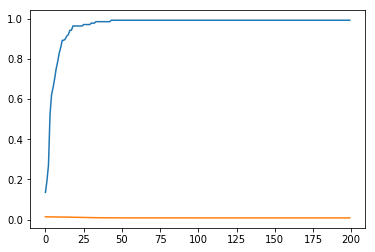

In [17]:
import matplotlib.pyplot as plt
plt.plot(acc_record)
plt.plot(loss_record)

In [11]:
print(dataset[0].val_mask, dataset[0].test_mask)
print(dataset[0].val_mask.sum(), dataset[0].test_mask.sum())

tensor([False, False, False,  ..., False, False, False]) tensor([False, False, False,  ...,  True,  True,  True])
tensor(500) tensor(1000)


In [25]:
dataset[0].val_mask

tensor([False, False, False,  ..., False, False, False])

In [30]:
pred * dataset[0].val_mask.to(device)

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0')